In [1]:
import yaml
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob 
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import shutil
from zipfile import ZipFile
import numpy as np
import chart_studio.plotly as py
import chart_studio
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
df_train=pd.read_csv(config['train_path']+'/train.csv')
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
df_train['disance']=abs(df_train['pickup_latitude']-df_train['dropoff_latitude'])+abs(df_train['pickup_longitude']-df_train['dropoff_longitude'])

In [5]:
df_train['key']=pd.to_datetime(df_train['key'])
df_train['pickup_datetime']=pd.to_datetime(df_train['pickup_datetime'])

In [6]:
df_train.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,disance
count,55423856,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07,5.542348e+07
mean,2012-03-21 00:18:49.821667584,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00,3.220488e-01
min,2009-01-01 00:00:27.000000100,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00,0.000000e+00
25%,2010-08-19 21:09:08.750000128,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00,1.581900e-02
50%,2012-03-19 11:39:24.500000256,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00,2.763200e-02
75%,2013-10-18 17:27:55.500000256,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00,5.034300e-02
max,2015-06-30 23:59:54.000000300,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02,1.131478e+04
std,NaN,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00,1.653626e+01


In [7]:
df_train['pickup_datetime_month'] = df_train['pickup_datetime'].dt.month
df_train['pickup_datetime_year'] = df_train['pickup_datetime'].dt.year
df_train['pickup_datetime_day_of_week'] = df_train['pickup_datetime'].dt.weekday
df_train['pickup_datetime_day_of_hour'] = df_train['pickup_datetime'].dt.hour

In [8]:
df_train = df_train.drop(df_train[df_train['fare_amount'] < 0].index)

In [9]:
df_train.head()
df_temp = df_train.drop(columns=['key', 'pickup_datetime'])


/home/bdr/kaggle/kaggle/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.

/home/bdr/kaggle/kaggle/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.



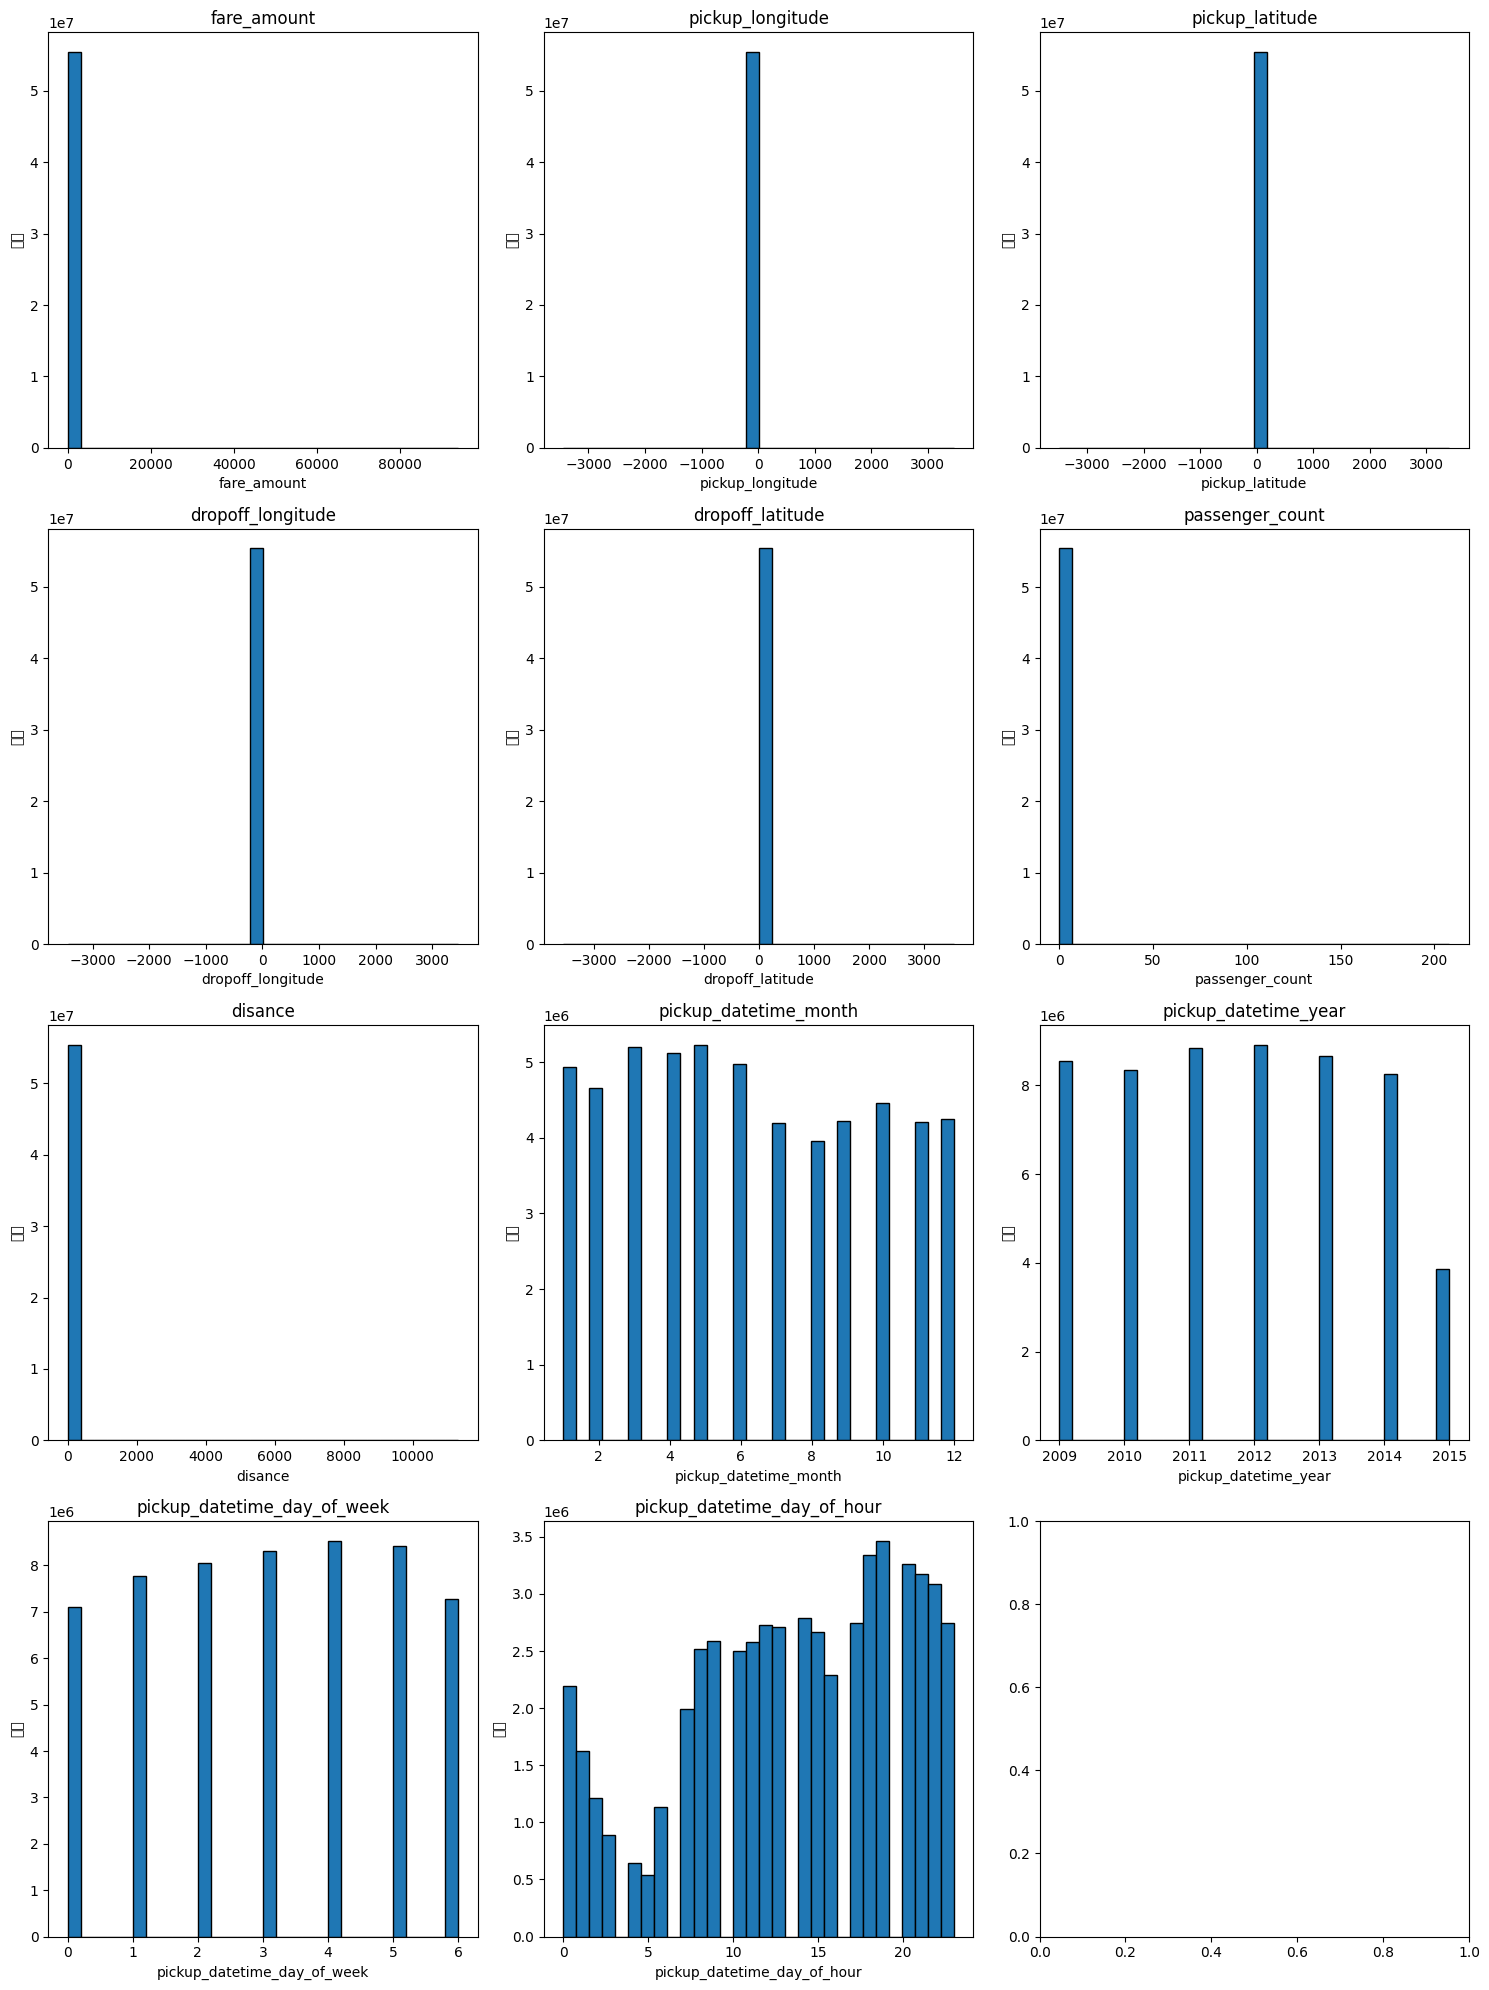

In [10]:
fig, ax = plt.subplots(4, 3, figsize=(15, 20), tight_layout=True)

for i, column in enumerate(df_temp.columns):
    ax[i//3, i%3].hist(df_temp[column], bins=30, edgecolor='black')
    ax[i//3, i%3].set_title(column)
    ax[i//3, i%3].set_xlabel(column)
    ax[i//3, i%3].set_ylabel('頻度')

plt.show()


<Axes: >

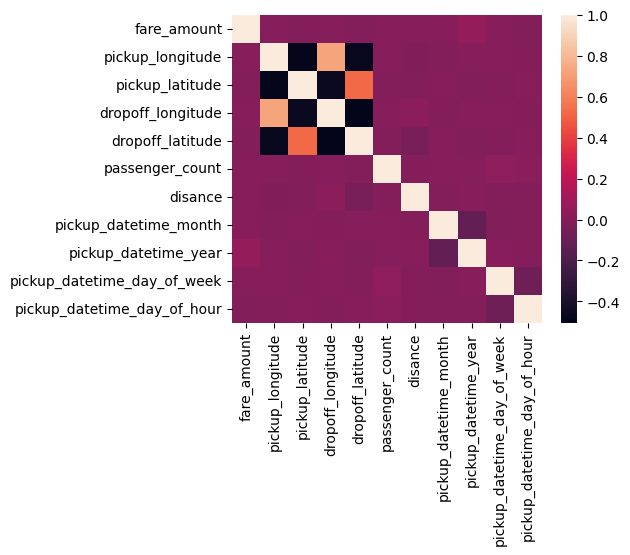

In [11]:
import seaborn as sns
corr=df_temp.corr()

fig,ax=plt.subplots(figsize=(5,4))
sns.heatmap(corr)

In [12]:
for column in df_temp.columns:
    # NaN値を除外してヒストグラムを計算
    data = df_temp[column].dropna()
    if len(data) > 0:
        hist, bin_edges = np.histogram(data)
        print(f"{column}のヒストグラム:")
        for i, (count, edge) in enumerate(zip(hist, bin_edges[:-1])):
            print(f"  ビン {i+1}: 範囲 {edge:.2f} - {bin_edges[i+1]:.2f}, 要素数 {count}")
    else:
        print(f"{column}には有効なデータがありません")
    print("\n")

fare_amountのヒストグラム:
  ビン 1: 範囲 0.00 - 9396.34, 要素数 55421399
  ビン 2: 範囲 9396.34 - 18792.67, 要素数 0
  ビン 3: 範囲 18792.67 - 28189.01, 要素数 0
  ビン 4: 範囲 28189.01 - 37585.34, 要素数 0
  ビン 5: 範囲 37585.34 - 46981.68, 要素数 0
  ビン 6: 範囲 46981.68 - 56378.02, 要素数 0
  ビン 7: 範囲 56378.02 - 65774.35, 要素数 1
  ビン 8: 範囲 65774.35 - 75170.69, 要素数 0
  ビン 9: 範囲 75170.69 - 84567.02, 要素数 1
  ビン 10: 範囲 84567.02 - 93963.36, 要素数 1


pickup_longitudeのヒストグラム:
  ビン 1: 範囲 -3442.06 - -2752.09, 要素数 89
  ビン 2: 範囲 -2752.09 - -2062.12, 要素数 72
  ビン 3: 範囲 -2062.12 - -1372.15, 要素数 78
  ビン 4: 範囲 -1372.15 - -682.19, 要素数 727
  ビン 5: 範囲 -682.19 - 7.78, 要素数 55393389
  ビン 6: 範囲 7.78 - 697.75, 要素数 26819
  ビン 7: 範囲 697.75 - 1387.72, 要素数 52
  ビン 8: 範囲 1387.72 - 2077.69, 要素数 45
  ビン 9: 範囲 2077.69 - 2767.66, 要素数 84
  ビン 10: 範囲 2767.66 - 3457.63, 要素数 47


pickup_latitudeのヒストグラム:
  ビン 1: 範囲 -3492.26 - -2802.16, 要素数 79
  ビン 2: 範囲 -2802.16 - -2112.05, 要素数 86
  ビン 3: 範囲 -2112.05 - -1421.95, 要素数 41
  ビン 4: 範囲 -1421.95 - -731.84, 要素数 69
  ビン 5: 範囲

In [13]:
df_new=df_train[df_train['fare_amount']>50000]
df_new

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,disance,pickup_datetime_month,pickup_datetime_year,pickup_datetime_day_of_week,pickup_datetime_day_of_hour
18859340,2013-08-20 11:52:52.000000100,61550.86,2013-08-20 11:52:52+00:00,-73.967711,40.755965,-73.945572,40.747666,1,0.030438,8,2013,1,11
41032263,2015-02-24 08:57:37.000000400,93963.36,2015-02-24 08:57:37+00:00,-73.994461,40.712353,-74.012543,40.702904,2,0.027531,2,2015,1,8
41186018,2015-05-03 09:35:20.000000100,75747.02,2015-05-03 09:35:20+00:00,-73.967949,40.792355,-73.990898,40.738976,1,0.076328,5,2015,6,9


In [14]:
df_train = df_train.drop(df_train[df_train['fare_amount'] > 50000].index)
df_train

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,disance,pickup_datetime_month,pickup_datetime_year,pickup_datetime_day_of_week,pickup_datetime_day_of_hour
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.011742,6,2009,0,17
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,0.107481,1,2010,1,16
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.019212,8,2011,3,0
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.029386,4,2012,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,0.027194,3,2010,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55423851,2014-03-15 03:28:00.000000700,14.0,2014-03-15 03:28:00+00:00,-74.005272,40.740027,-73.963280,40.762555,1,0.064520,3,2014,5,3
55423852,2009-03-24 20:46:20.000000200,4.2,2009-03-24 20:46:20+00:00,-73.957784,40.765530,-73.951640,40.773959,1,0.014573,3,2009,1,20
55423853,2011-04-02 22:04:24.000000400,14.1,2011-04-02 22:04:24+00:00,-73.970505,40.752325,-73.960537,40.797342,1,0.054985,4,2011,5,22
55423854,2011-10-26 05:57:51.000000200,28.9,2011-10-26 05:57:51+00:00,-73.980901,40.764629,-73.870605,40.773963,1,0.119630,10,2011,2,5


In [15]:
df_train = df_train[df_train['passenger_count'] <= 20]
df_train

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,disance,pickup_datetime_month,pickup_datetime_year,pickup_datetime_day_of_week,pickup_datetime_day_of_hour
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.011742,6,2009,0,17
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,0.107481,1,2010,1,16
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.019212,8,2011,3,0
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.029386,4,2012,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,0.027194,3,2010,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55423851,2014-03-15 03:28:00.000000700,14.0,2014-03-15 03:28:00+00:00,-74.005272,40.740027,-73.963280,40.762555,1,0.064520,3,2014,5,3
55423852,2009-03-24 20:46:20.000000200,4.2,2009-03-24 20:46:20+00:00,-73.957784,40.765530,-73.951640,40.773959,1,0.014573,3,2009,1,20
55423853,2011-04-02 22:04:24.000000400,14.1,2011-04-02 22:04:24+00:00,-73.970505,40.752325,-73.960537,40.797342,1,0.054985,4,2011,5,22
55423854,2011-10-26 05:57:51.000000200,28.9,2011-10-26 05:57:51+00:00,-73.980901,40.764629,-73.870605,40.773963,1,0.119630,10,2011,2,5


latittudeが0のものを消していいのかの検討は後でする。mapplotで試してみる。
ここでは一回、モデルを作ることに専念する

In [16]:
import lightgbm as lbgm

In [17]:
df_train = df_train.drop(['key','pickup_datetime'], axis = 1)
X_train=df_train.iloc[:,df_train.columns!='fare_amount']
y_train=df_train['fare_amount'].values
print(X_train.shape)


(55421330, 10)


In [18]:
# モデルの学習
train_set = lbgm.Dataset(X_train, y_train)
lgb_model = lbgm.train(config['lgb_params'], train_set=train_set, num_boost_round=300)

# 予測
y_pred = lgb_model.predict(X_train,num_iteration=lgb_model.best_iteration)

# RMSEの計算
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print(f"トレーニングデータのRMSE: {rmse:.4f}")

トレーニングデータのRMSE: 4.5702


In [21]:
df_test=pd.read_csv(config['train_path']+'/test.csv')
df_test.head()

submission=pd.read_csv(config['train_path']+'/sample_submission.csv')

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [22]:
df_test['disance']=abs(df_test['pickup_latitude']-df_test['dropoff_latitude'])+abs(df_test['pickup_longitude']-df_test['dropoff_longitude'])

df_test['pickup_datetime']=pd.to_datetime(df_test['pickup_datetime'])

df_test['pickup_datetime_month'] = df_test['pickup_datetime'].dt.month
df_test['pickup_datetime_year'] = df_test['pickup_datetime'].dt.year
df_test['pickup_datetime_day_of_week'] = df_test['pickup_datetime'].dt.weekday
df_test['pickup_datetime_day_of_hour'] = df_test['pickup_datetime'].dt.hour

df_test = df_test.drop(['key','pickup_datetime'], axis = 1)

In [27]:
pred_test_y = lgb_model.predict(df_test, num_iteration = lgb_model.best_iteration)

submission['fare_amount'] = pred_test_y
submission.to_csv(config['output_path']+'/submission_taxi.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.255438
1,2015-01-27 13:08:24.0000003,11.536774
2,2011-10-08 11:53:44.0000002,5.036056
3,2012-12-01 21:12:12.0000002,9.794603
4,2012-12-01 21:12:12.0000003,17.067718
5,2012-12-01 21:12:12.0000005,11.864742
6,2011-10-06 12:10:20.0000001,5.848557
7,2011-10-06 12:10:20.0000003,53.955416
8,2011-10-06 12:10:20.0000002,13.210212
9,2014-02-18 15:22:20.0000002,8.071692


In [1]:
#スコアを提出する際にはターミナルでこれを打つ
#! scp -i ~/.ssh/id_rsa -r bdr@10.242.91.173:'/home/bdr/kaggle/texi-tax/data/output/submission_taxi.csv' ~/kaggle/